Create a T-S diagram using the CTD measurements. 
Distinguish the northern and southern parts of the front

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import alborexdata
import json
import cmocean

## Configuration

In [2]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

In [3]:
figdir = config["figdir"]
figname = "fig04"

## Load data and front position

In [4]:
f = alborexdata.Front()
ctd = alborexdata.CTD()
f.get_from_file("../data/front_coordinates.dat")
f.smooth()
ctd.get_from_netcdf(config["datafiles"]["ctd"])

In [5]:
f.get_from_file("../data/front_coordinates.dat")
f.smooth()
ctd.get_from_netcdf(config["datafiles"]["ctd"])

### Select zone of interest (CTD)

In [6]:
goodlons = np.where((f.lon >= -1.) & (f.lon <= -0.25))[0]
lon2fit = f.lon[goodlons]
lat2fit = f.lat[goodlons]

## Fit coordinates of the front

In [7]:
# We use a quadratic function for the fit
def front_fun(x, a, b, c):
    return a * x**2 + b * x + c

In [8]:
popt, pcov = curve_fit(front_fun, lon2fit, lat2fit)

### Simple plot to check it worked

In [9]:
latcalc = front_fun(np.array(f.lon), popt[0], popt[1], popt[2])

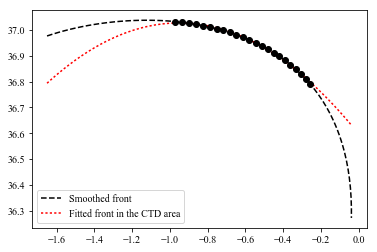

In [10]:
plt.plot(f.lon, f.lat, "k--", label="Smoothed front")
plt.plot(f.lon, latcalc, "r:", label="Fitted front in the CTD area")
plt.plot(lon2fit, lat2fit, "ko")
plt.legend()
plt.show()
plt.close()

### Find CTD casts north/south of the front 

In [11]:
latcalc = front_fun(ctd.lon, popt[0], popt[1], popt[2])
ctd_north = np.where(ctd.lat > latcalc)[0]
ctd_south = np.where(ctd.lat <= latcalc)[0]

Another check

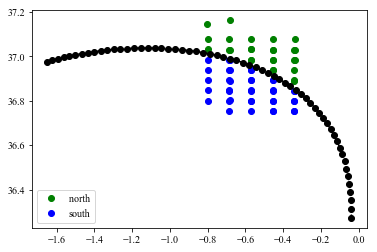

In [12]:
plt.figure()
plt.plot(ctd.lon[ctd_north], ctd.lat[ctd_north], "go", label="north")
plt.plot(ctd.lon[ctd_south], ctd.lat[ctd_south], "bo", label="south")
plt.plot(f.lon, f.lat, "ko--")
plt.legend(loc=3)
plt.show()
plt.close()

## Main figure

Compute min and max values to ensure the same axis limits.

In [13]:
xmin, xmax = np.nanmin(ctd.salinity), np.nanmax(ctd.salinity)
ymin, ymax = np.nanmin(ctd.temperature), np.nanmax(ctd.temperature)

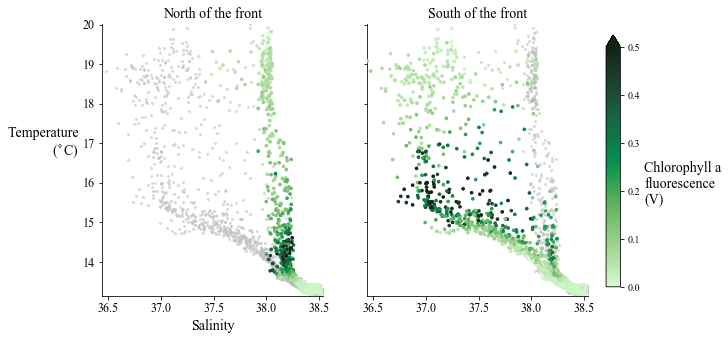

In [16]:
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.scatter(ctd.salinity[ctd_north, :], ctd.temperature[ctd_north, :], 
            c=ctd.chloro[ctd_north, :], s=7, vmin=0, vmax=.5, zorder=3,
            cmap=cmocean.cm.algae)
plt.plot(ctd.salinity[ctd_south, :], ctd.temperature[ctd_south, :], 
            "o", color=".75", alpha=.5, ms=2, zorder=2)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title("North of the front", fontsize=14)
plt.xlabel("Salinity", fontsize=14)
plt.ylabel("Temperature\n($^{\circ}$C)", rotation=0, ha="right", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

ax2 = plt.subplot(122)
ax2.set_yticklabels("")
scat2 = plt.scatter(ctd.salinity[ctd_south, :], ctd.temperature[ctd_south, :],
            c=ctd.chloro[ctd_south, :], s=7, vmin=0, vmax=.5, zorder=3,
            cmap=cmocean.cm.algae)
plt.plot(ctd.salinity[ctd_north, :], ctd.temperature[ctd_north, :], 
            "o", color=".75", alpha=.5, ms=2, zorder=2)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title("South of the front", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.02, 0.7])
cb = plt.colorbar(scat2, cax=cbar_ax, extend="max")
cb.set_label("Chlorophyll a\nfluorescence\n(V)", rotation=0, ha="left", fontsize=14)
plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()